In [1]:
import random
import warnings
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

warnings.filterwarnings("ignore")
import networkx as nx
from dowhy.utils import plot
from dowhy import gcm, CausalModel

import matplotlib.pyplot as plt
import json


In [3]:
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete.CPD import TabularCPD

#### Asia / chest clinic bayesian network

In [5]:
dataset = pd.read_csv('../data/asia10K.csv')
dataset.head()

,smoke,lung,asia,tub,either,xray,bronc,dysp
0,yes,yes,no,no,yes,yes,yes,yes
1,no,no,no,no,no,yes,yes,yes
2,no,no,no,no,no,no,yes,yes
3,no,no,no,no,no,no,yes,yes
4,yes,no,no,no,no,no,yes,no


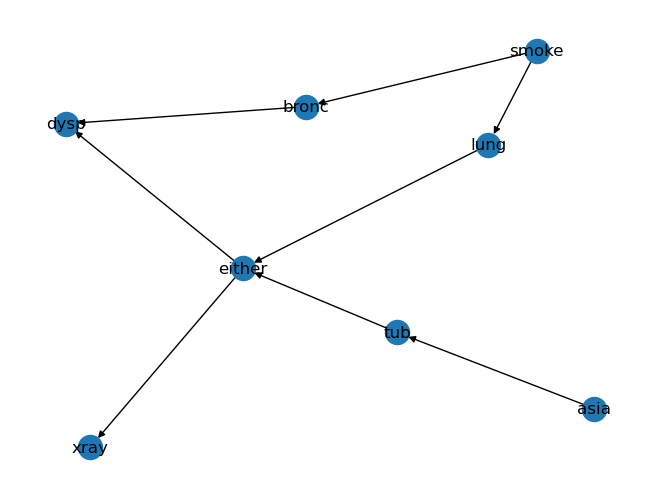

In [6]:
G = nx.DiGraph()

G.add_nodes_from(["asia", "smoke", "tub", "lung", "bronc", "either", "xray", "dysp"])

edges = [
    # tuple of direction (from, to)
    ("asia", "tub"),
    ("smoke", "lung"),
    ("smoke", "bronc"),
    ("tub", "either"),
    ("lung", "either"),
    ("either", "xray"),
    ("either", "dysp"),
    ("bronc", "dysp"),
]


G.add_edges_from(edges)
nx.write_gml(G, "asia_network.gml")

nx.draw(G, with_labels=True)
plt.plot()

In [7]:
asia_bn = BayesianNetwork(edges)
asia_bn.fit(dataset)

In [9]:
asia_bn.get_cpds()

[<TabularCPD representing P(asia:2) at 0x204ab3890a0>,
 <TabularCPD representing P(tub:2 | asia:2) at 0x204ab389220>,
 <TabularCPD representing P(smoke:2) at 0x204ab389040>,
 <TabularCPD representing P(lung:2 | smoke:2) at 0x204ab389130>,
 <TabularCPD representing P(bronc:2 | smoke:2) at 0x204ab37a490>,
 <TabularCPD representing P(either:2 | lung:2, tub:2) at 0x204ab37ae20>,
 <TabularCPD representing P(xray:2 | either:2) at 0x204ab37adc0>,
 <TabularCPD representing P(dysp:2 | bronc:2, either:2) at 0x204ab37adf0>]

#### Inference based on evidence (hard evidence)


In [37]:
from pgmpy.inference import VariableElimination
asia_infer = VariableElimination(asia_bn)

# variables: var that we interested in
# evidence: the evidence on certain node
# joint: show as joint distribution or not
q = asia_infer.query(variables=["bronc", 'tub'], evidence={"smoke": "no", 'dysp':'no'}, joint=False)
print(q)
# this syntax is used bcs variables > 1
for factor in q.values():
    print(factor)

{'bronc': <DiscreteFactor representing phi(bronc:2) at 0x204ab7ca6d0>, 'tub': <DiscreteFactor representing phi(tub:2) at 0x204ab7ca0d0>}
+------------+--------------+
| bronc      |   phi(bronc) |
+============+==============+
| bronc(no)  |       0.9169 |
+------------+--------------+
| bronc(yes) |       0.0831 |
+------------+--------------+
+----------+------------+
| tub      |   phi(tub) |
+==========+============+
| tub(no)  |     0.9963 |
+----------+------------+
| tub(yes) |     0.0037 |
+----------+------------+


#### Inference based on evidence (virtual evidence)

In [57]:
q = asia_infer.query(variables=["lung"], evidence={"smoke": "no", 'dysp':'no'})
print(q)

+-----------+-------------+
| lung      |   phi(lung) |
+===========+=============+
| lung(no)  |      0.9965 |
+-----------+-------------+
| lung(yes) |      0.0035 |
+-----------+-------------+


In [82]:
do_bronc = asia_bn.do(['bronc'])
do_bronc.get_cpds()
asia_infer_do_bronc = VariableElimination(do_bronc)
q = asia_infer_do_bronc.query(variables=["bronc"], evidence={"smoke": "no", 'dysp':'no'})
print(q), print(do_bronc.get_cpds('bronc'))

+------------+--------------+
| bronc      |   phi(bronc) |
+============+==============+
| bronc(no)  |       0.8493 |
+------------+--------------+
| bronc(yes) |       0.1507 |
+------------+--------------+
+------------+----------+
| bronc(no)  | 0.553941 |
+------------+----------+
| bronc(yes) | 0.446059 |
+------------+----------+


(None, None)

In [107]:
do_tub = asia_bn.do(['tub'])
do_tub.get_cpds()
asia_infer_do_tub = VariableElimination(do_tub)
q = asia_infer_do_tub.query(variables=["asia"], evidence={"smoke": "yes", 'dysp':'no'})

# asia will stand alone
print(do_tub.get_cpds('asia'))

+-----------+--------+
| asia(no)  | 0.9906 |
+-----------+--------+
| asia(yes) | 0.0094 |
+-----------+--------+
